In [1]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
#%cd drive/MyDrive/commfy

# Multiclass Classifier to Predict Feet Items 
The objective of this notebook is to build a machine learning model that predicts feet items (shoe & sock combination) by leveraging k-nearest neighbors and random forest classifiers.

## 1. Importing required modules and loading data file
In the first section of this notebook, we have to import all neccessary libraries, required modules and essential packages. After running them in this cell, we will be able to use them in subsequent cells throughout the notebook.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for displaying plots
import seaborn as sns; sns.set(style='ticks') # plotting package for histograms
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from matplotlib import cm #for creating color maps

In [4]:
#skipping some rows and reading only relevant parts into dataframe
feets = pd.read_csv('input_data.csv', skiprows=2) 
#starting index from 1 in a dataframe
feets.index = feets.index + 1

<hr style="border:2px solid gray"> </hr>

## 2. Exploratory data analysis (EDA) and data cleaning
In this section, it is essential to conduct the initial investigations on data to discover the patterns, identify outliers and spot noises with the help of summary statistics and graphical representations. The goal of EDA is to summarize the important characteristics of data in order to gain better understanding of the dataset and prepare data for machine learning.

### The first step in EDA is to pre-process the dataset
After importing the dataset and having a quick glance at a data, we transformed raw data to well-formed dataset.

In [5]:
#viewing the dataset & checking if data has been read into a dataframe object
feets.head(10)

,Unnamed: 0,a,b,c,d,e,f
1,0,23.633087,1.0,cloudy,1.0,1.0,-2
2,1,38.742237,1.0,sunny,0.0,1.0,0
3,2,NaN,1.0,sunny,1.0,2.0,2
4,3,22.249957,1.0,sunny,0.0,1.0,-5
5,4,27.007875,1.0,cloudy,0.0,0.0,-2
6,5,37.733175,1.0,sunny,1.0,1.0,0
7,6,23.452793,1.0,sunny,2.0,NaN,3
8,7,29.576284,1.0,cloudy,0.0,0.0,2
9,8,20.621831,1.0,cloudy,0.0,0.0,0
10,9,26.420650,1.0,cloudy,1.0,2.0,44


In [6]:
#renaming the columns with self-explanatory titles
feets.rename({"a": "temperature", "b": "feet_class", "c": "weather","d": "sex", "e":"heaviness_trip", "f":"heat_perception"},axis = 1, inplace = True)

In [7]:
#slicing out the unneccesary column
feets = feets.iloc[: , 1:]

In [8]:
#checking how many values are missing for each column
feets.isnull().sum(axis=0)

temperature        4
feet_class         2
weather            2
sex                1
heaviness_trip     4
heat_perception    0
dtype: int64

The are few missing values, therefore, it is statistics insignificant to drop all of them.

In [9]:
#dropping rows with NaN values
feets.dropna(inplace = True)

In [10]:
#finding out the columns & their corresponding data types
feets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24988 entries, 1 to 25000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      24988 non-null  float64
 1   feet_class       24988 non-null  float64
 2   weather          24988 non-null  object 
 3   sex              24988 non-null  float64
 4   heaviness_trip   24988 non-null  float64
 5   heat_perception  24988 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB


In [11]:
#converting feet_class, sex and heaviness_trip from float to int
feets = feets.astype({"feet_class":'int', "sex":'int', "heaviness_trip": 'int'}) 
display(feets.dtypes)

temperature        float64
feet_class           int32
weather             object
sex                  int32
heaviness_trip       int32
heat_perception      int64
dtype: object

In [12]:
#getting unique values of heat_perception series object
feets['heat_perception'].unique()

array([-2,  0, -5,  2, 44,  4, -4,  5, -3, -1,  3,  1], dtype=int64)

In [13]:
#replacing the incorrect value the correct one
feets['heat_perception'].replace([44],[4], inplace=True)

In [14]:
#checking if the replacement have been placed
feets['heat_perception'].unique()

array([-2,  0, -5,  2,  4, -4,  5, -3, -1,  3,  1], dtype=int64)

In [15]:
feets['weather'].unique()

array(['cloudy', 'sunny', 'sunnny', 'cloudi', 'Sunny', 'snowy', 'rainy',
       'rayny', 'raiiny'], dtype=object)

In [16]:
#harmonising values in weather state column with df.replace()
feets.replace(['cloudi', 'sunnny','Sunny', 'rayny','raiiny'], ['cloudy', 'sunny', 'sunny', 'rainy','rainy'],inplace=True)
feets['weather'].replace(['cloudy','sunny','snowy','rainy'],[4,1,3,2],inplace=True)

In [17]:
#checking if the changes have been placed
feets['weather'].unique()

array([4, 1, 3, 2], dtype=int64)

In [18]:
feets.head(6)

,temperature,feet_class,weather,sex,heaviness_trip,heat_perception
1,23.633087,1,4,1,1,-2
2,38.742237,1,1,0,1,0
4,22.249957,1,1,0,1,-5
5,27.007875,1,4,0,0,-2
6,37.733175,1,1,1,1,0
8,29.576284,1,4,0,0,2


In [19]:
round(feets.describe(), 2) #for the statistical summary of numerical data

,temperature,feet_class,weather,sex,heaviness_trip,heat_perception
count,24988.00,24988.00,24988.00,24988.00,24988.00,24988.00
mean,9.21,3.00,2.33,0.53,1.00,0.02
std,15.72,1.41,1.14,0.54,0.82,3.17
min,-17.19,1.00,1.00,0.00,0.00,-5.00
25%,-5.51,2.00,1.00,0.00,0.00,-3.00
50%,5.54,3.00,2.00,1.00,1.00,0.00
75%,24.47,4.00,4.00,1.00,2.00,3.00
max,55.27,5.00,4.00,2.00,2.00,5.00


### The second step is to conduct descriptive statistics of a datatset.
We call the describe() function to gain insights into the shape of each attribute by creating summary statistics by viewing central tendency, mean, median, standard deviation, percentile and max values.

### The third step is to create bar charts.
The bar charts on categorical variables show the class distribution of the independent variables (x axis distinct items, y axis frequency).

In [20]:
#checking if changes have been placed
feets.head()

,temperature,feet_class,weather,sex,heaviness_trip,heat_perception
1,23.633087,1,4,1,1,-2
2,38.742237,1,1,0,1,0
4,22.249957,1,1,0,1,-5
5,27.007875,1,4,0,0,-2
6,37.733175,1,1,1,1,0


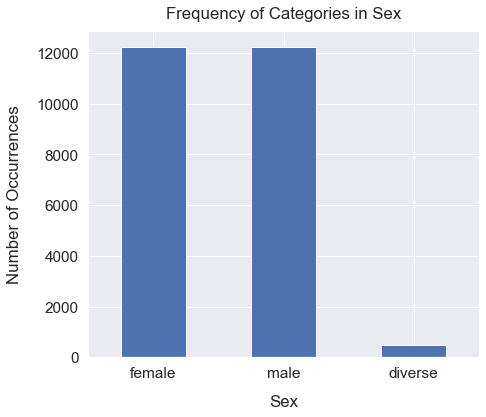

In [21]:
#creating a bar chart on the frequency of categories in the 'sex' variable
sns.set(font_scale=1.4)
feets['sex'].replace([0, 1, 2],['male','female','diverse']).value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Sex", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in Sex", y=1.02);

There are equal frequencies for female and male categories. The occurences of diverse category in this dataset corresponds to the relatively less number of diverse people (intersex?) in general.

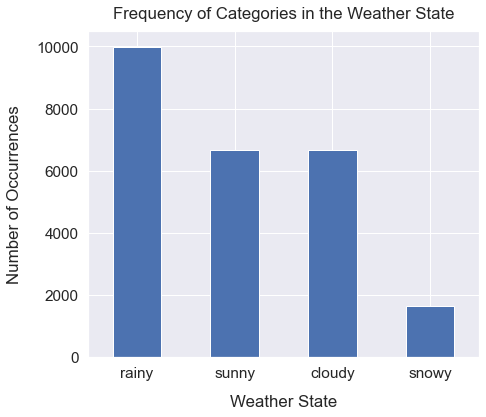

In [22]:
#creating a bar chart on the frequency of categories in the 'weather' variable
sns.set(font_scale=1.4)
feets['weather'].replace([4,1,3,2],['cloudy','sunny','snowy','rainy']).value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Weather State", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in the Weather State", y=1.02);

The frequency of cloudy category in the variable weather is minimal which is also displayed in the bart chart. The dataset contains high frequency of sunny weather state and approximately twice as less of rainy observations.

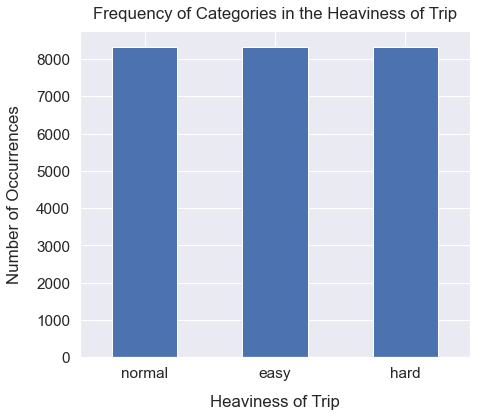

In [23]:
##creating a bar chart on the frequency of categories in the 'heaviness_trip' variable
sns.set(font_scale=1.4)
feets["heaviness_trip"].replace([0, 1, 2],['easy','normal','hard']).value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Heaviness of Trip", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in the Heaviness of Trip", y=1.02);

There are almost equal occurrences of all three categories in the weather state.

### This forth step is to plot histograms/kernel density plots for each variables. 
This visualization technique will enable us to see how frequently data in each class occur in the dataset. Namely, it will graphically show the frequency of different data points in the dataset, location of the center of data, the spread of dataset, skewness of dataset and presence of outliers.

Text(0.5, 1.0, 'Histogram of Temperature')

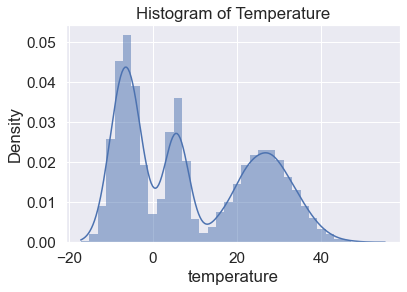

In [24]:
sns.histplot(feets["temperature"], kde = True, stat="density", linewidth=0).set_title("Histogram of Temperature")

Provide interpretation of the histogram

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Low shoes + socks'),
  Text(1, 0, 'boots + socks'),
  Text(2, 0, 'boots + wool socks'),
  Text(3, 0, 'rainproof shoes + socks'),
  Text(4, 0, 'rainproof shoes + wool socks')])

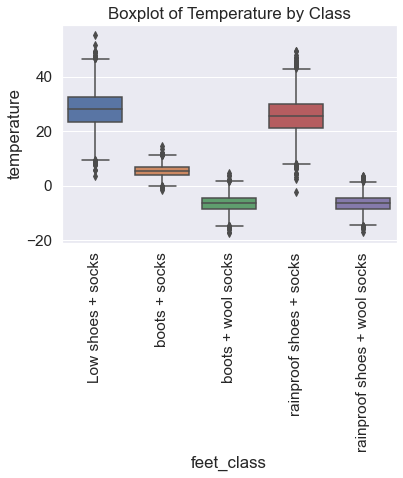

In [25]:
ax = sns.boxplot(x="feet_class", y="temperature", data=feets.replace([1,2,3,4,5],["Low shoes + socks", "boots + socks", "boots + wool socks", "rainproof shoes + socks", "rainproof shoes + wool socks"])).set_title("Boxplot of Temperature by Class")
plt.xticks(rotation=90)

Provide interpretation

### The last step of this section checks the correlation between features in a dataset by calling df.corr()

 
 It calculates the correlation between features pairwise excluding null values. Thus, we will gain understanding on one or multiple attributes that might be dependent on another attribute or a cause for another attribute.Feature correlations matter in predicting one attribute from another.

The cell computes a correlation matrix (Max's note: be mindful of the type of correlation and the scale level of the variable, pearson vs. spearman correlation)

In [26]:
round(feets.corr(),2)

,temperature,feet_class,weather,sex,heaviness_trip,heat_perception
temperature,1.00,-0.44,-0.04,0.03,0.03,0.08
feet_class,-0.44,1.00,-0.18,0.00,0.00,0.00
weather,-0.04,-0.18,1.00,-0.00,-0.01,0.00
sex,0.03,0.00,-0.00,1.00,0.80,0.01
heaviness_trip,0.03,0.00,-0.01,0.80,1.00,0.00
heat_perception,0.08,0.00,0.00,0.01,0.00,1.00


<hr style="border:2px solid gray"> </hr>

## 4. Model training
In this chapter, we will feed the ML algorithms with data to help identify and learn good values for all attributes involved.

The following code splits machine learning data into three datatsets: train-set, validation- and test-sets. The third set is important to test the final performance of the model. It is used only  on the fine-tuned model. Once it is used, it loses its "value".<p>

There is a big different in training data with the 'heat preception', therefore, we decided to train models with and without this feature.

In [27]:
class_name=feets['feet_class'].replace([1,2,3,4,5],["Low shoes + socks", "boots + socks", "boots + wool socks", "rainproof shoes + socks", "rainproof shoes + wool socks"]).unique()

In [28]:
# for our model we use such output data as temperature, sex, heat perception and weather state
X = feets[['temperature', 'sex','heat_perception', 'heaviness_trip','weather']]
y = feets['feet_class']

# default is 75% / 25% train-test split
X_train_help, X_test, y_train_help, y_test = train_test_split(X, y,test_size=0.20, random_state=0)
X_train, X_validation,y_train,y_validation =train_test_split(X_train_help, y_train_help,test_size=0.25, random_state=0)


### Dummy Classifiers
DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.

In [29]:
# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_predictions = dummy_majority.predict(X_test)
y_dummy_predictions
print(dummy_majority.score(X_test, y_test))

0.2026810724289716


### K-Nearest Neighbours Classification

In [30]:
knn = KNeighborsClassifier(n_neighbors = 1)

In [31]:
dec_tree_clf = DecisionTreeClassifier(max_depth = 4)

In [32]:
random_forest_clf =RandomForestClassifier(n_estimators=5)

In [33]:
print('Cross-validation (accuracy),knn',cross_val_score(knn, X_train, y_train, cv=5).mean())
print('Cross-validation (accuracy),dec_tree_clf' ,cross_val_score(dec_tree_clf, X_train, y_train, cv=5).mean())
print('Cross-validation (accuracy),random_forest_clf' ,cross_val_score(random_forest_clf, X_train, y_train, cv=5).mean())

Cross-validation (accuracy),knn 0.9815235276335162
Cross-validation (accuracy),dec_tree_clf 0.9917288862798607
Cross-validation (accuracy),random_forest_clf 0.9963981767549379


In [34]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [35]:
print(knn.score(X_test, y_test))


0.9873949579831933


we are training the k-nn algorithm and give out the accuracy for each k value from 1-100

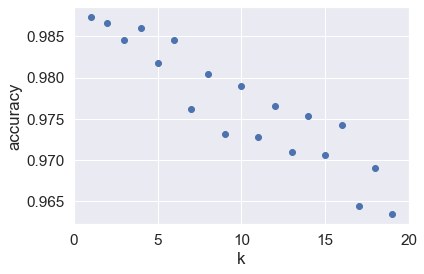

In [36]:
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

### Decision Tree: 
to compare the rule-based model with the decision tree for feet items

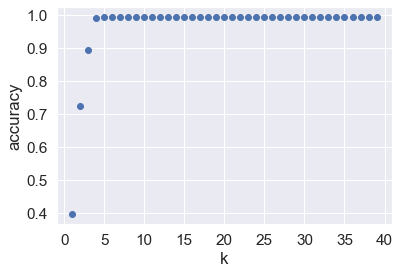

In [37]:
i_range = range(1,40)
scores= []

for i in i_range:
    dec_tree_clf = DecisionTreeClassifier(max_depth = i).fit(X_train, y_train)
    scores.append(dec_tree_clf.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(i_range, scores)
plt.xticks([0,5,10,15,20,25,30,35,40]);

In [47]:
dec_tree_clf = DecisionTreeClassifier(max_depth = )
dec_tree_clf.fit(X_train, y_train)
dec_tree_clf.score(X_test, y_test)

0.0

In [39]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

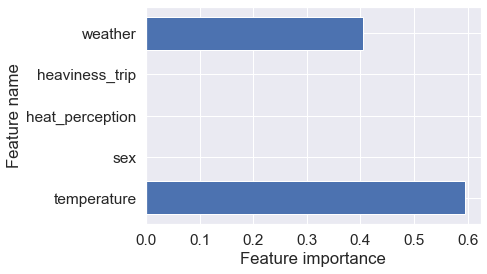

In [40]:

plot_feature_importances(dec_tree_clf,['temperature', 'sex','heat_perception', 'heaviness_trip','weather'] )

In [41]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,30), dpi=450)
plot_tree(dec_tree_clf,class_names=class_name,feature_names=['temperature', 'sex','heat_perception', 'heaviness_trip','weather'], filled=True)


[Text(5231.25, 8918.4375, 'temperature <= 0.682\ngini = 0.8\nsamples = 14992\nvalue = [2997, 3022, 3019, 2965, 2989]\nclass = boots + socks'),
 Text(2615.625, 6370.3125, 'weather <= 2.5\ngini = 0.505\nsamples = 5999\nvalue = [0, 29, 2998, 1, 2971]\nclass = boots + wool socks'),
 Text(1307.8125, 3822.1875, 'weather <= 1.5\ngini = 0.377\nsamples = 3961\nvalue = [0, 14, 975, 1, 2971]\nclass = rainproof shoes + wool socks'),
 Text(653.90625, 1274.0625, 'gini = 0.028\nsamples = 989\nvalue = [0, 14, 975, 0, 0]\nclass = boots + wool socks'),
 Text(1961.71875, 1274.0625, 'gini = 0.001\nsamples = 2972\nvalue = [0, 0, 0, 1, 2971]\nclass = rainproof shoes + wool socks'),
 Text(3923.4375, 3822.1875, 'temperature <= -0.491\ngini = 0.015\nsamples = 2038\nvalue = [0, 15, 2023, 0, 0]\nclass = boots + wool socks'),
 Text(3269.53125, 1274.0625, 'gini = 0.001\nsamples = 1994\nvalue = [0, 1, 1993, 0, 0]\nclass = boots + wool socks'),
 Text(4577.34375, 1274.0625, 'gini = 0.434\nsamples = 44\nvalue = [0, 14

### Random Forest Classifier
Adapt the following example code from Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001. For documentation click [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [42]:
X_train, y_train = make_classification(n_features=5)
clf =RandomForestClassifier(n_estimators=100)
clf.fit(X, y)
print(clf.score(X_test, y_test))

1.0


## 5. Model evaluation 
#### (more research is needed to define the relevant metrics)
In this step we will use corresponding metrics to test the ability of multi-class classifier by comparing the performance of different models and eventually, analysing the best peforming model my tuning different parameters.

### Use the trained classifier model to classify new objects

In [43]:
#new object classification on the "test set" as defined by Hastie et al. above

### Accuracy
This metric will be directly computed from the confusion matrix. <p> Is already Featured in training the model

### Multi-class confusion matrix
Confusion Matrix is used to know the performance of a Machine learning classification. It is represented in a matrix form. [Confusion Matrix](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/#:~:text=Confusion%20Matrix%20is%20used%20to,between%20Actual%20and%20predicted%20values.&text=Confusion%20Matrix%20has%204%20terms,and%20False%20Negative(FN).) gives a comparison between Actual and predicted values

In [44]:
#some code

### Precision and recall
Precision quantifies the number of positive class predictions that actually belong to the positive class. Recall quantifies the number of positive class predictions made out of all positive examples in the dataset. [For more read the following blog](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2).

In [45]:
#some code

### K-fold cross-validation
In this step, we will leverage k-fold cross validation  to estimate the skill of the model on new data.

In [46]:
#some code


## 6. Model deployment

ML learning part is not getting deployed in the app

Further steps: save the model as a file, and create an .xls file with the testset (as defined by Hastie et al., 2009) and corresponding predictions in an additional column Details to be aligned with WD team (e.g., Flask interface).